<a href="https://colab.research.google.com/github/umaabhyankar/AQI-Predictor/blob/main/feature_view_model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -U hopsworks --quiet

!pip install xgboost --q

In [12]:
import os
import datetime
import time
import json
import pickle
import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

In [14]:
air_quality_fg_api = fs.get_or_create_feature_group(
    name = 'air_quality_fg_api',
    version = 1
)

In [15]:
query = air_quality_fg_api.select_all()

In [16]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv_api',
    version=1,
    query=query
)

In [ ]:
td_version, td_job = feature_view.create_training_data(
    description = 'Air Quality dataset',
    data_format = 'csv',
    write_options = {'wait_for_job': True}
)

In [18]:
air_quality_fg_historical = fs.get_or_create_feature_group(
    name = 'air_quality_fg_historical',
    version = 1
)

In [19]:
query = air_quality_fg_historical.select_all()

In [20]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv_historical',
    version=1,
    query=query
)

In [ ]:
td_version, td_job = feature_view.create_training_data(
    description = 'Air Quality dataset',
    data_format = 'csv',
    write_options = {'wait_for_job': True}
)

In [24]:
X, _ = feature_view.get_training_data(
    training_dataset_version=1
)

In [25]:
X = X.loc[~((X['pm25']==0) | (X['pm10']==0) | (X['o3']==0)| (X['no2']==0)| (X['so2']==0)| (X['co']==0))]

In [26]:
X = X[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'aqi']]

In [ ]:
X

In [28]:
y = X.pop('aqi')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
start_of_cell = time.time()

xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("R squared:", r2)

end_of_cell = time.time()
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

In [31]:
df_ = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})

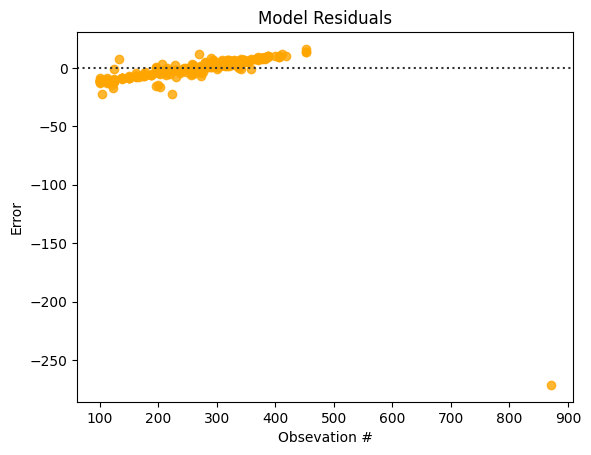

In [32]:
residplot = sns.residplot(data=df_, x="y_true", y="y_pred", color='orange')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()
fig = residplot.get_figure()
fig.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

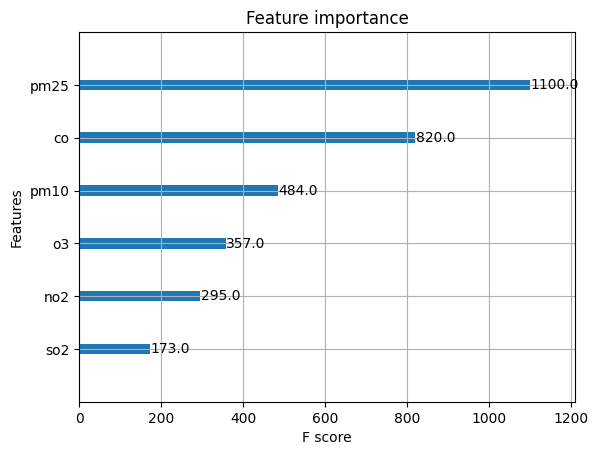

In [33]:
from xgboost import plot_importance


plot_importance(xgb_regressor, max_num_features=25)

In [34]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X)
output_schema = Schema(y)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

In [ ]:
model_dir="air_quality_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(xgb_regressor, model_dir + '/xgboost_regressor.pkl')

fig.savefig(model_dir + "/residplot.png")

In [ ]:
aq_model = mr.python.create_model(
    name="air_quality_xgboost_model",
    metrics={
        "RMSE": rmse,
        "MSE": mse,
        "R squared": r2
    },
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Air Quality predictor")

aq_model.save(model_dir)

In [35]:
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1
)

saved_model_dir = retrieved_model.download()

In [36]:
retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")

In [37]:
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [38]:
air_quality_fg_api = fs.get_or_create_feature_group(
    name = 'air_quality_fg_api',
    version = 1
)

In [39]:
query = air_quality_fg_api.select_all()

In [40]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv_api',
    version=1,
    query=query
)

In [41]:
X_api, _ = feature_view.get_training_data(
    training_dataset_version=1
)

In [42]:
X_api

,date,pm25,pm10,o3,no2,so2,co,n_count,pm10_si,pm25_si,o3_si,no2_si,so2_si,co_si,aqi
0,2023-07-15T00:00:00.000Z,77.0,43.0,5.0,0.0,0.0,0.0,NaN,43.0,156.666667,5.0,0.0,0.0,0.0,156.666667
1,2023-07-13T00:00:00.000Z,94.0,53.0,5.0,0.0,0.0,0.0,NaN,53.0,213.333333,5.0,0.0,0.0,0.0,213.333333
2,2023-07-14T00:00:00.000Z,73.0,39.0,5.0,0.0,0.0,0.0,NaN,39.0,143.333333,5.0,0.0,0.0,0.0,143.333333
3,2023-07-11T00:00:00.000Z,105.0,67.0,6.0,0.0,0.0,0.0,NaN,67.0,250.000000,6.0,0.0,0.0,0.0,250.000000
4,2023-07-12T00:00:00.000Z,113.0,62.0,5.0,0.0,0.0,0.0,NaN,62.0,276.666667,5.0,0.0,0.0,0.0,276.666667
5,2023-07-16T00:00:00.000Z,79.0,39.0,4.0,0.0,0.0,0.0,NaN,39.0,163.333333,4.0,0.0,0.0,0.0,163.333333
6,2023-07-17T00:00:00.000Z,80.0,43.0,0.0,0.0,0.0,0.0,NaN,43.0,166.666667,0.0,0.0,0.0,0.0,166.666667


In [43]:
X_prediction = X_api[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'aqi']]

In [44]:
y_prediction = X_prediction.pop('aqi')

In [45]:
predictions = retrieved_xgboost_model.predict(X_prediction)

In [46]:
y_prediction

0    156.666667
1    213.333333
2    143.333333
3    250.000000
4    276.666667
5    163.333333
6    166.666667
Name: aqi, dtype: float64

In [47]:
predictions

array([147.1614 , 182.1447 , 137.00853, 244.8433 , 262.39313, 152.49136,
       156.69888], dtype=float32)

In [48]:
X_api['predictions'] = predictions

In [51]:
# X_api.to_csv('X_api.csv')

In [54]:
X_api.sort_values('date', inplace=True)

In [67]:
X_api['date'] = pd.to_datetime(X_api['date']).dt.tz_localize(None)

In [69]:
X_api = X_api.loc[X_api['date']>pd.to_datetime('today')]

In [76]:
X_api = X_api[['date', 'predictions']]

In [77]:
X_api['predictions'] = [int(i) for i in X_api.predictions]

In [80]:
X_api.rename(columns={'date': 'Date', 'predictions': 'Air Quality Index'}, inplace=True)

In [81]:
X_api

,Date,Air Quality Index
4,2023-07-12,262
1,2023-07-13,182
2,2023-07-14,137
0,2023-07-15,147
5,2023-07-16,152
6,2023-07-17,156
